In [151]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from matplotlib.image import imread
from matplotlib.image import imsave

from sklearn.cluster import KMeans

import pycuda.driver as cuda
import pycuda.compiler as compiler
import pycuda.autoinit  # This automatically initializes the context

import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Algorithm Implementation

In [152]:
def initialize_centroids(data, k):
    """
    Initializes the centroids by randomly selecting k points from the data.

    :param data: A 2D numpy array where each row is a data point
    :param k: Number of clusters
    :return: A 2D numpy array of k centroids
    """
    n_samples, n_features = data.shape
    centroids = data[np.random.choice(n_samples, k, replace=False)]
    return centroids


In [153]:
def closest_centroid(data, centroids):
    """
    Finds the index of the closest centroid for each data point.

    :param data: A 2D numpy array where each row is a data point
    :param centroids: A 2D numpy array of current centroids
    :return: A 1D numpy array where each element is the index of the closest centroid for the corresponding data point
    """
    distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
    return np.argmin(distances, axis=1)


In [154]:
def compute_centroids(data, labels, k):
    """
    Computes the new centroids as the mean of the data points assigned to each cluster.

    :param data: A 2D numpy array where each row is a data point
    :param labels: A 1D numpy array of cluster indices corresponding to the closest centroids
    :param k: Number of clusters
    :return: A 2D numpy array of the new centroids
    """
    n_features = data.shape[1]
    centroids = np.zeros((k, n_features))
    
    for i in range(k):
        points_in_cluster = data[labels == i]
        if points_in_cluster.size:
            centroids[i] = points_in_cluster.mean(axis=0)
    
    return centroids


In [155]:
def k_means(data, k, max_iters=100, tol=1e-4):
    """
    Performs K-Means clustering on the input data.

    :param data: A 2D numpy array where each row is a data point
    :param k: Number of clusters
    :param max_iters: Maximum number of iterations to run the algorithm
    :param tol: Tolerance for convergence, i.e., if the centroids do not move much, the algorithm will stop
    :return: A tuple of (centroids, labels) where centroids is a 2D numpy array of final centroids and
             labels is a 1D numpy array of cluster indices for each data point
    """
    # Step 1: Initialize the centroids
    centroids = initialize_centroids(data, k)

    for _ in range(max_iters):
        # Step 2: Assign each data point to the closest centroid
        labels = closest_centroid(data, centroids)

        # Step 3: Calculate new centroids as the mean of the points in each cluster
        new_centroids = compute_centroids(data, labels, k)

        # Step 4: Check for convergence (if centroids do not change much)
        if np.linalg.norm(new_centroids - centroids) < tol:
            break

        centroids = new_centroids

    return centroids, labels


# Testing the Algorithm

In [156]:
def generate_data():
    nPerClust_SA = 100
    C1 = [1,1]
    C2 = [5,1]
    C3 = [3,-2]
    C4 = [4,4]
    blur = 1
    radius = np.array([0.8,0.8,0.8,0.8])
    
    C1Data = np.array([C1[0]+radius[0]*np.random.randn(nPerClust_SA)*blur , C1[1]+radius[0]*np.random.randn(nPerClust_SA)*blur ])
    C2Data = np.array([C2[0]+radius[1]*np.random.randn(nPerClust_SA)*blur , C2[1]+radius[1]*np.random.randn(nPerClust_SA)*blur ])
    C3Data = np.array([C3[0]+radius[2]*np.random.randn(nPerClust_SA)*blur , C3[1]+radius[2]*np.random.randn(nPerClust_SA)*blur ])
    C4Data = np.array([C4[0]+radius[3]*np.random.randn(nPerClust_SA)*blur , C4[1]+radius[3]*np.random.randn(nPerClust_SA)*blur ])

    np_data = np.hstack((C1Data,C2Data,C3Data,C4Data)).T

    Label1 = np.zeros((np.max(C1Data.shape),1))
    Label2 = Label1 + 1
    Label3 = Label1 + 2
    Label4 = Label1 + 3
    np_labels = np.vstack((Label1,Label2,Label3,Label4))
    
    return np_labels, np_data

In [157]:
# Plot the clusters
def plot_clusters(np_data, labels, k, centroids):
    colors = ['ro', 'go', 'bo', 'mo', 'co', 'yo', 'ko']  # Colors for different clusters

    for i in range(k):
        cluster_data = np_data[labels == i]
        plt.plot(cluster_data[:, 0], cluster_data[:, 1], colors[i % len(colors)], label=f"Cluster {i+1}")
        plt.plot(centroids[i][0],centroids[i][1], 'ko', label=f"Cluster {i+1}")

    plt.legend()
    plt.title(f"Clusters for k={k}")
    plt.show()

In [158]:
def cluster_and_plot(np_data):
    for k in [2, 3, 4]:  # Perform clustering for k=2, 3, and 4
        centroids, labels = k_means(np_data, k)
        plot_clusters(np_data, labels, k, centroids)


# Plotting the Results

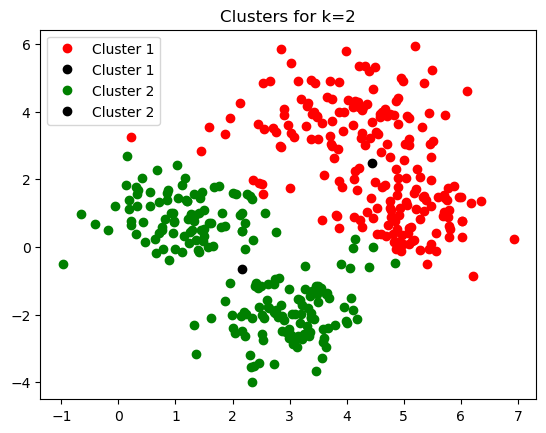

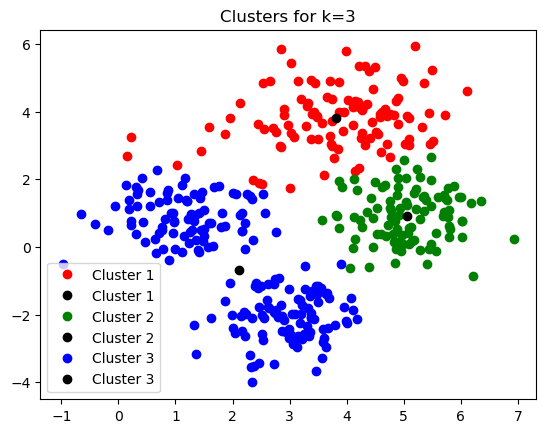

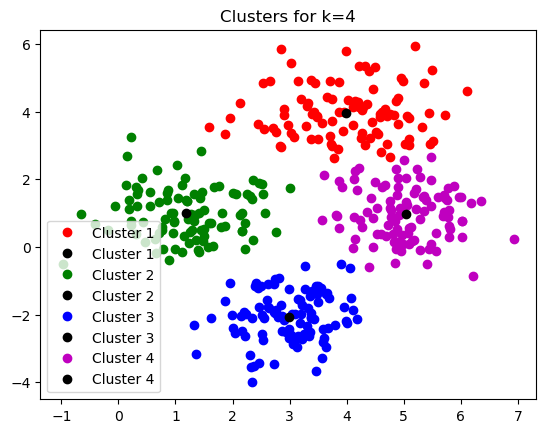

In [159]:
# Main script
labels, np_data = generate_data()  # Generate the data

# Cluster and plot for 2, 3, and 4 clusters
cluster_and_plot(np_data)

# Evaluating the Algorithm

In [160]:
# Function to compute the Euclidean distance
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b)**2))

# Function to calculate inertia (within-cluster sum of squares)
def calculate_inertia(X, clusters, centroids):
    inertia = 0
    for i, point in enumerate(X):
        centroid = centroids[clusters[i]]
        inertia += euclidean_distance(point, centroid)**2
    return inertia/X.shape[0]

In [161]:
# Function to plot the error vs number of clusters
def plot_error_vs_clusters(k_values, errors):
    """
    Plot the error of K-Means vs number of clusters.
    :param k_values: List of k values (number of clusters)
    :param errors: List of errors corresponding to each k
    """
    plt.plot(k_values, errors, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Total Error')
    plt.title('K-Means Error vs Number of Clusters')
    plt.grid(True)
    plt.show()

# Plotting the Error

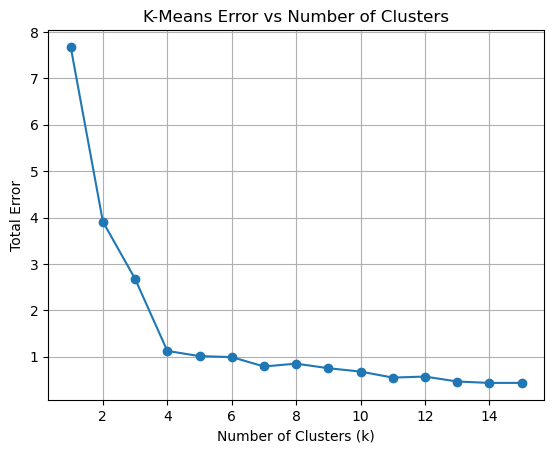

In [162]:
# Evaluate K-Means for k = 1 to 15 and calculate errors
k_values = range(1, 16)
errors = []

for k in k_values:
    centroids, labels = k_means(np_data, k)
    error = calculate_inertia(np_data, labels, centroids)
    errors.append(error)

# Plot the error as a function of the number of clusters
plot_error_vs_clusters(k_values, errors)

# Limitations of k-means

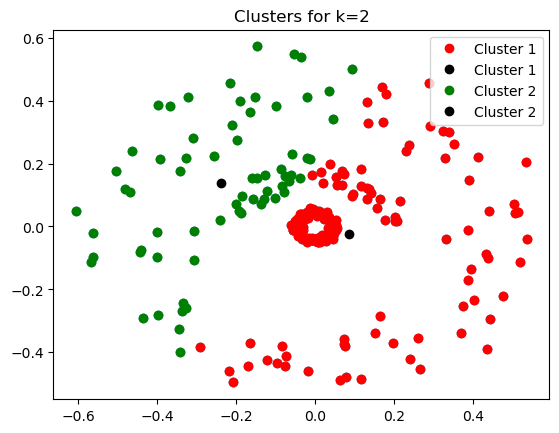

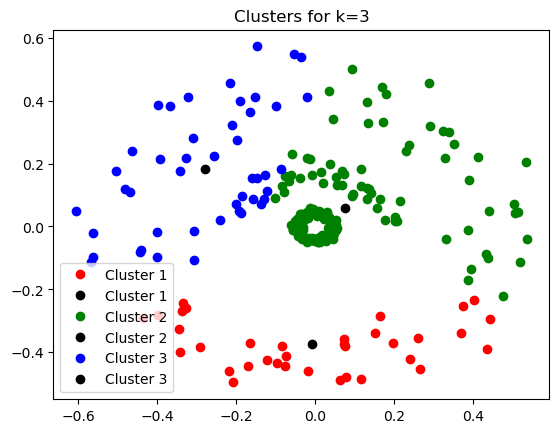

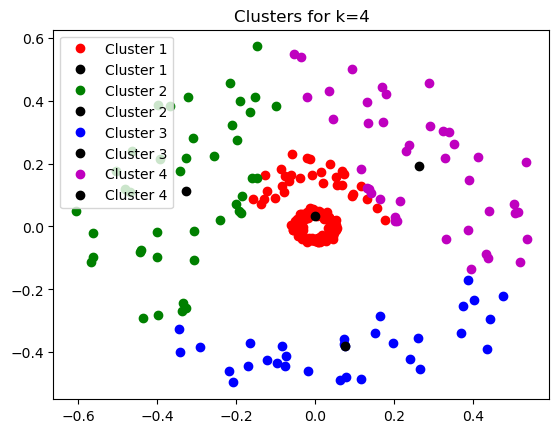

k=1, Total Error=0.09
k=2, Total Error=0.07
k=3, Total Error=0.05
k=4, Total Error=0.03
k=5, Total Error=0.02
k=6, Total Error=0.02
k=7, Total Error=0.02
k=8, Total Error=0.01
k=9, Total Error=0.01
k=10, Total Error=0.01
k=11, Total Error=0.01
k=12, Total Error=0.01
k=13, Total Error=0.01
k=14, Total Error=0.01


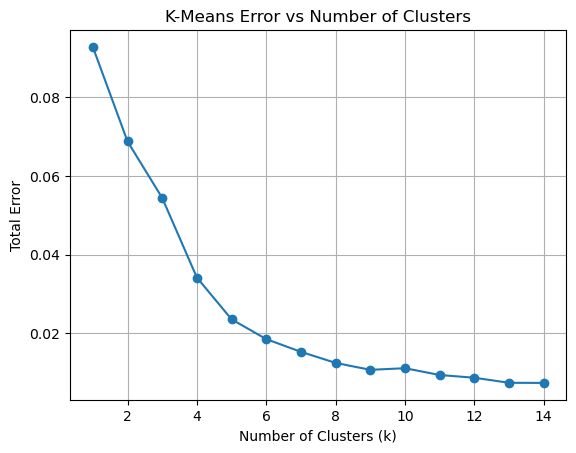

In [163]:

x,_ = make_circles(n_samples=100,noise=0.1,shuffle=False)
x1 = 0.5* x
x2 = 0.2* x[x[:,1]>0,:]
x3 = 0.05*x 

Data = np.vstack((x1,x2,x3))

plt.scatter(Data[:,0],Data[:,1])


# Cluster and plot for k=2, 3, and 4 clusters
for k in [2, 3, 4]:
    centroids, labels = k_means(Data, k)
    plot_clusters(Data, labels, k, centroids)

# Evaluate the Algorithm
# Plot error vs number of clusters (k=1 to 10)
k_values = range(1, 15)
errors = []

for k in k_values:
    centroids, labels = k_means(Data, k)
    error = calculate_inertia(Data, labels, centroids)
    errors.append(error)
    print(f"k={k}, Total Error={error:.2f}")

# Plot the error as a function of the number of clusters
plot_error_vs_clusters(k_values, errors)

<div dir="rtl">
همانطور که در نمودار بالا مشخص است، به دسته‌های منطقی نرسیدیم و این محدودیت الگوریتم را نشان می‌دهد.
</div>

## 3D -> 2D

In [164]:
a = np.array([[[1,2,3],[4,5,6],[7,8,9]], [[10,11,12],[13,14,15],[16,17,18]],[[19,20,21],[22,23,24],[25,26,27]]])
print(f"shape a: {a.shape}")
print(a)
b = a.reshape(-1,3)
print(f"\nshape b: {b.shape}")
print(b)

shape a: (3, 3, 3)
[[[ 1  2  3]
  [ 4  5  6]
  [ 7  8  9]]

 [[10 11 12]
  [13 14 15]
  [16 17 18]]

 [[19 20 21]
  [22 23 24]
  [25 26 27]]]

shape b: (9, 3)
[[ 1  2  3]
 [ 4  5  6]
 [ 7  8  9]
 [10 11 12]
 [13 14 15]
 [16 17 18]
 [19 20 21]
 [22 23 24]
 [25 26 27]]


image shape: (512, 512, 3)
pixels shape: (262144, 3)
labels shape: (262144,)
centroids shape: (16, 3)
compressed_image shape: (512, 512, 3)


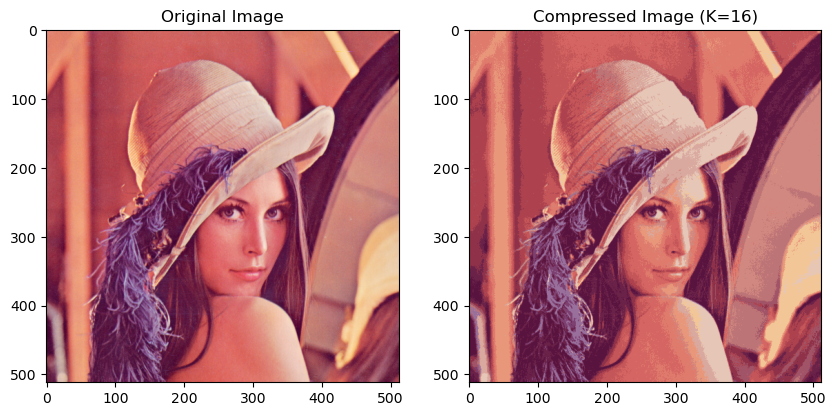

In [165]:
# Load the image
# image = imread('OwlPic.jpg')
image = imread('Lenna.png')
print(f"image shape: {image.shape}")

# Reshape the image to a 2D array of pixels
pixels = image.reshape(-1, 3)
print(f"pixels shape: {pixels.shape}")

# Run the K-Means algorithm on the pixel data with k=16
k = 16
centroids, labels = k_means(pixels, k)
print(f"labels shape: {labels.shape}")
print(f"centroids shape: {centroids.shape}")

# Replace each pixel with the corresponding cluster center
compressed_image = centroids[labels].reshape(image.shape)
print(f"compressed_image shape: {compressed_image.shape}")

# imsave('compressed_image.jpg', compressed_image.astype(np.uint8))
imsave('compressed_image.png', compressed_image)

# Plot the original and compressed images for comparison
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')

# Compressed image
plt.subplot(1, 2, 2)
plt.imshow(compressed_image)
plt.title('Compressed Image (K=16)')

plt.show()


<div dir="rtl">
برای مقایسه بین حجم دو تصویر به فایل توجه کنید. 
</div>

# K-means implemented with `CUDA` (4x faster)


## kernel code

In [166]:
kernel_code = """
__global__ void assign_clusters(float *data, float *centroids, int *labels, int num_points, int num_centroids) {
    int idx = blockDim.x * blockIdx.x + threadIdx.x;  // Global thread index

    if (idx < num_points) {
        float min_dist = 1e10;  // A large number representing infinity
        int closest_centroid = 0;

        // Find the closest centroid for each point
        for (int i = 0; i < num_centroids; i++) {
            float dist = 0.0;
            for (int j = 0; j < 3; j++) {  // Assuming 3 channels (RGB)
                float diff = data[idx * 3 + j] - centroids[i * 3 + j];
                dist += diff * diff;  // Squared Euclidean distance
            }
            if (dist < min_dist) {
                min_dist = dist;
                closest_centroid = i;
            }
        }
        labels[idx] = closest_centroid;  // Assign the closest centroid to the label
    }
}

__global__ void update_centroids(float *data, float *centroids, int *labels, int num_points, int num_centroids) {
    int idx = blockDim.x * blockIdx.x + threadIdx.x;  // Global thread index

    if (idx < num_centroids) {
        float sum[3] = {0.0, 0.0, 0.0};  // Sum of points for each centroid
        int count = 0;

        // Calculate the new centroid position
        for (int i = 0; i < num_points; i++) {
            if (labels[i] == idx) {
                for (int j = 0; j < 3; j++) {
                    sum[j] += data[i * 3 + j];
                }
                count++;
            }
        }

        // Update centroid only if count > 0 to avoid division by zero
        if (count > 0) {
            for (int j = 0; j < 3; j++) {
                centroids[idx * 3 + j] = sum[j] / count;
            }
        }
    }
}
"""

## host code

In [167]:
# Compile the kernel code
mod = compiler.SourceModule(kernel_code)

# Function to run K-Means clustering on the GPU
def cuda_kmeans(pixels, num_classes, max_iters=100):
    num_points = pixels.shape[0]
    
    # Allocate memory on the GPU
    data_ptr = cuda.mem_alloc(pixels.nbytes)
    centroids_ptr = cuda.mem_alloc(num_classes * pixels.shape[1] * pixels.dtype.itemsize)
    labels_ptr = cuda.mem_alloc(num_points * np.int32().itemsize)

    # Copy pixel data to GPU
    cuda.memcpy_htod(data_ptr, pixels)

    # Randomly initialize centroids
    centroids = np.random.rand(num_classes, 3).astype(np.float32)
    cuda.memcpy_htod(centroids_ptr, centroids)

    for _ in range(max_iters):
        # Assign clusters
        assign_clusters = mod.get_function("assign_clusters")
        block_size = 256
        grid_size = (num_points + block_size - 1) // block_size
        assign_clusters(data_ptr, centroids_ptr, labels_ptr, np.int32(num_points), np.int32(num_classes), block=(block_size, 1, 1), grid=(grid_size, 1))

        # Update centroids
        update_centroids = mod.get_function("update_centroids")
        update_centroids(data_ptr, centroids_ptr, labels_ptr, np.int32(num_points), np.int32(num_classes), 
                 block=(block_size, 1, 1), 
                 grid=((num_classes + block_size - 1) // block_size, 1))

    # Copy results back to host
    labels = np.empty(num_points, dtype=np.int32)
    centroids = np.empty((num_classes, 3), dtype=np.float32)
    cuda.memcpy_dtoh(labels, labels_ptr)
    cuda.memcpy_dtoh(centroids, centroids_ptr)

    # Free GPU memory
    data_ptr.free()
    centroids_ptr.free()
    labels_ptr.free()

    return labels, centroids

# Example Usage
# original_image = imread('OwlPic.jpg')
original_image = imread('Lenna.png')
pixels = original_image.reshape(-1, 3).astype(np.float32)  # Flatten the image to (num_pixels, 3)

# Run K-Means on GPU
num_classes = 16
labels, centroids = cuda_kmeans(pixels, num_classes)

# Create the compressed image
compressed_image = centroids[labels].reshape(original_image.shape)
print(f"compressed_image shape: {compressed_image.shape}")

# Save the compressed image
# plt.imsave('compressed_image_cuda.jpg', compressed_image.astype(np.uint8))
plt.imsave('compressed_image_cuda.png', compressed_image)

compressed_image shape: (512, 512, 3)


### Explanation of Hyperparameters in `KMeans`

1. **`n_clusters`**:
   - Specifies the number of clusters to form. 
   - Affects the algorithm’s accuracy: too few clusters may cause underfitting, while too many may lead to overfitting. More clusters also increase computational complexity.

2. **`init`**:
   - Determines the method for initializing centroids. Options include:
     - `'k-means++'`: Selects initial centers to speed up convergence (default).
     - `'random'`: Randomly selects centroids.
   - Impacts convergence speed and the quality of clustering. `'k-means++'` generally leads to faster and more stable convergence, reducing the chances of poor local minima.

3. **`n_init`**:
   - The number of times K-means will run with different centroid seeds. The final result is the best output in terms of inertia (sum of squared distances).
   - Increases robustness by avoiding local minima, but higher values also increase computation time.

4. **`max_iter`**:
   - Sets the maximum number of iterations for a single run.
   - A higher limit allows more time for convergence but may increase computation time if the algorithm converges slowly.

5. **`tol`**:
   - Defines the tolerance for declaring convergence. If the change in cluster centers falls below this threshold, the algorithm stops.
   - Smaller values lead to more precise clusters but may require more iterations, increasing computation time.

6. **`verbose`**:
   - Controls the verbosity (level of output information) during execution.
   - Does not impact model performance, but helps in debugging and monitoring.

7. **`random_state`**:
   - Determines the random number generation for centroid initialization. Setting a value ensures reproducible results.
   - No effect on performance but useful for consistency in results during experimentation.

8. **`copy_x`**:
   - If `True`, the input data is copied, ensuring the original data is not modified. 
   - Impacts memory usage: disabling it (`False`) can improve memory efficiency.

9. **`algorithm`**:
   - Specifies the algorithm to compute clusters:
     - `'lloyd'`: Standard K-means algorithm.
     - `'elkan'`: Uses triangle inequality to reduce distance computations (faster with Euclidean distances).
   - The `'elkan'` option speeds up computation for large datasets but is only applicable to Euclidean distances.


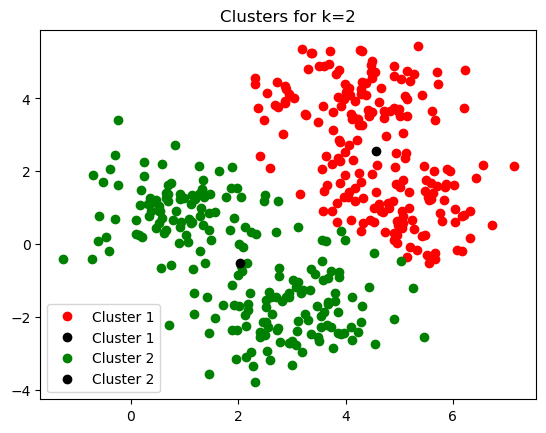

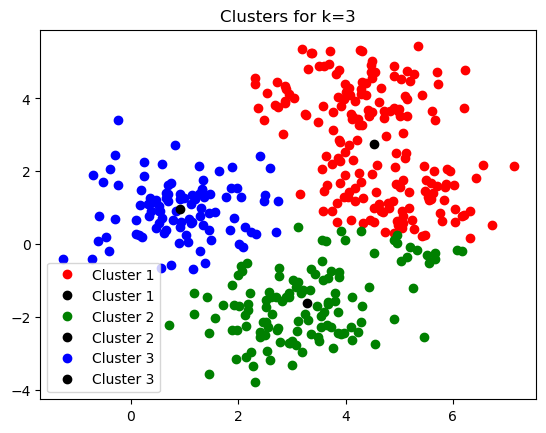

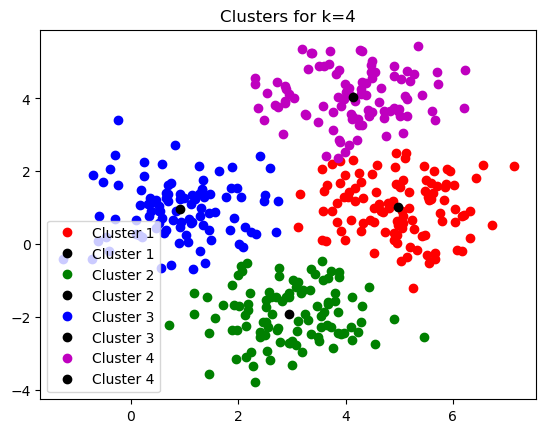

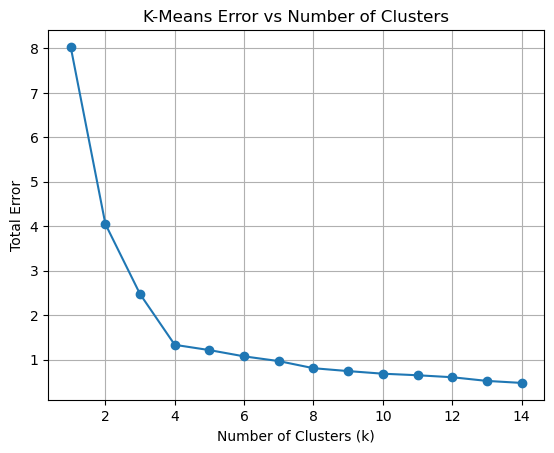

In [168]:
# Apply KMeans from scikit-learn
def sklearn_kmeans(np_data, k):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(np_data)
    return kmeans.cluster_centers_, kmeans.labels_

# Cluster and plot for 2, 3, and 4 clusters using scikit-learn
def sklearn_cluster_and_plot(np_data):
    for k in [2, 3, 4]:
        centroids, labels = sklearn_kmeans(np_data, k)
        plot_clusters(np_data, labels, k, centroids)

# Main script
labels, np_data = generate_data()  # Generate the data

# Cluster and plot using scikit-learn for 2, 3, and 4 clusters
sklearn_cluster_and_plot(np_data)

# Evaluate KMeans for k = 1 to 15 using scikit-learn and calculate errors
sklearn_errors = []
for k in k_values:
    centroids, labels = sklearn_kmeans(np_data, k)
    error = calculate_inertia(np_data, labels, centroids)
    sklearn_errors.append(error)

# Plot the error as a function of the number of clusters using scikit-learn
plot_error_vs_clusters(k_values, sklearn_errors)


<div dir="rtl">
نتیجه خیلی شبیه با چیزی است که پیاده کرده ایم
<div>

# Practice

# ۱

<div dir="rtl">
یکی از راه‌هایی که برای انتخاب مقدار بهینه استفاده میشود این است که جایی که شیب خطا ناگهان کم میشود را به عنوان مقدار دسته بندی انتخاب کنیم. برای مثال در نمودار بالا در مقدار ۴  شیب خطا ناگهان افت میکند پس این مقدار مناسبی برای دسته بندی است.
<div>

# ۲

<div dir="rtl">
به دلیل اینکه الگوریتم ذکر شده براساس فاصله کار می‌کند. درحالی که دسته بندی داده های اشاره شده بر اساس فاصله نیست. به بیان دیگر فاصله ای که در الگوریتم کامین استفاده میشود فاصله از تمام جهات است،‌مانند دایره. پس این الگوریتم سعی میکند به مراکز داده هایی که به از لحاظ شعاع به آن نزدیک هستند را جذب کند. 

برای دسته بندی صحیح این داده‌ها باید از روش ها مبتی بر چگالی استفاده کرد
<div>

# ۵

### Load the Dataset

In [169]:
df = pd.read_csv('./archive/Mall_Customers.csv')

print(df.head())

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


### Exploratory Data Analysis (EDA)

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64
       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000           61.500000               50.000000
75%    150.250000   49.000000           78.000000               73.000000
max    200.000000   70.000000          137.000000               99.000000


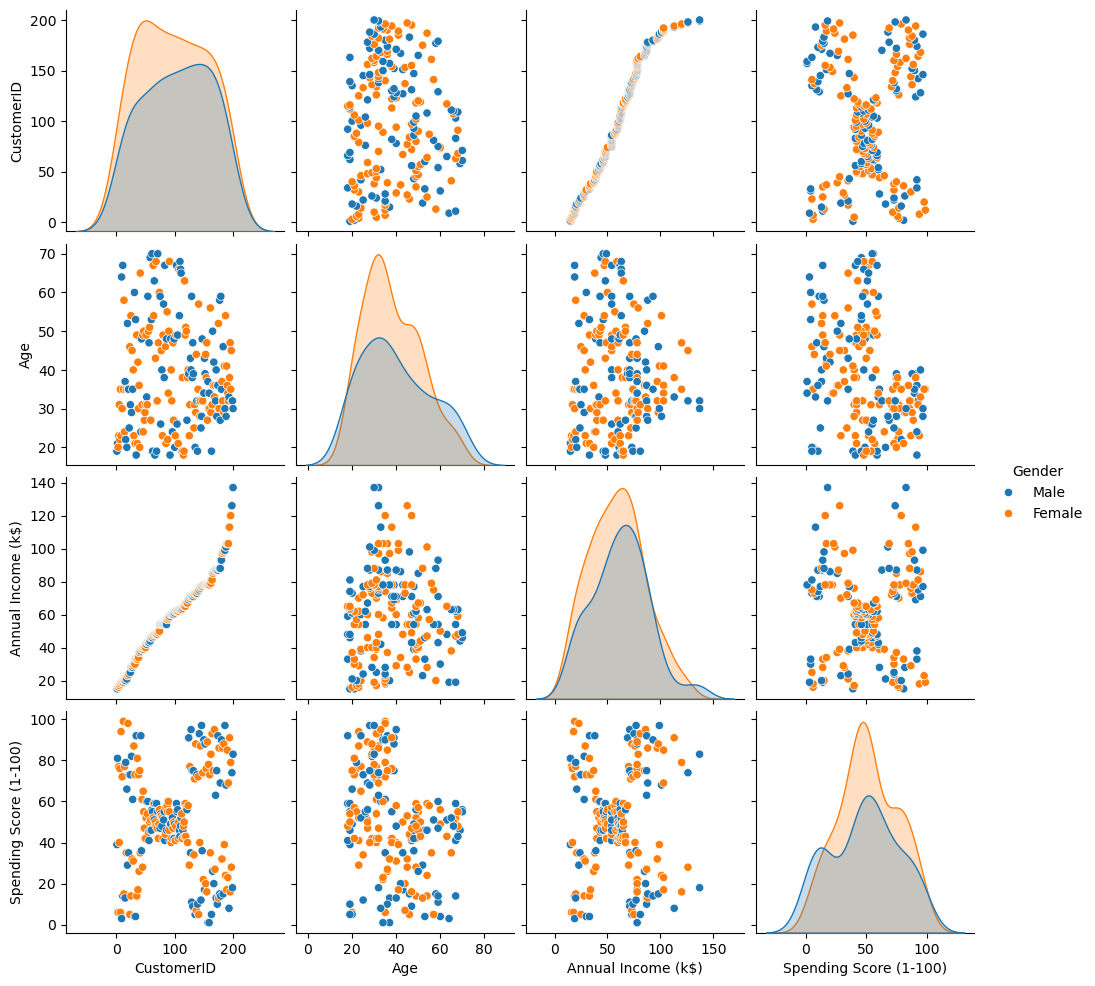

In [170]:
# Check for missing values
print(df.isnull().sum())

# Statistical summary
print(df.describe())

# Visualize distributions
sns.pairplot(df, hue='Gender')
plt.show()

### Handle Categorical Variables

In [171]:
# Initialize LabelEncoder
le = LabelEncoder()

# Encode Gender
df['Gender'] = le.fit_transform(df['Gender'])

print(df.head())

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1       1   19                  15                      39
1           2       1   21                  15                      81
2           3       0   20                  16                       6
3           4       0   23                  16                      77
4           5       0   31                  17                      40


### Feature Selection

Select relevant features for clustering.

In [172]:
X = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

### Feature Scaling

In [173]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Determine the Optimal Number of Clusters

1. **`Elbow Method`**:

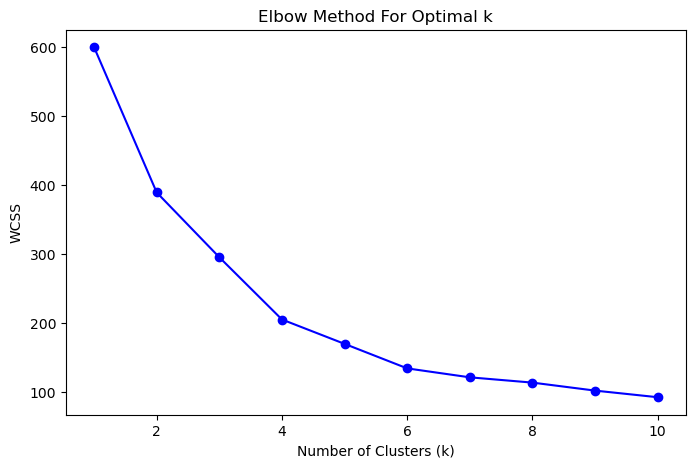

In [174]:
wcss = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8,5))
plt.plot(K, wcss, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method For Optimal k')
plt.show()

2. **`Silhouette Score`**:

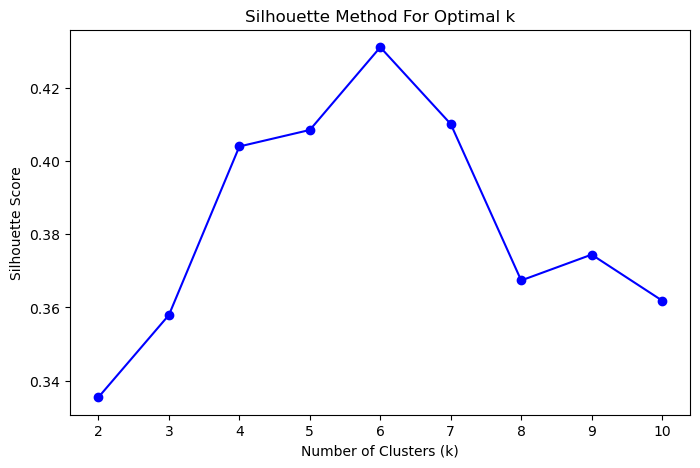

In [175]:
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

# Plot Silhouette Scores
plt.figure(figsize=(8,5))
plt.plot(range(2,11), silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For Optimal k')
plt.show()


<div dir="rtl">
با توجه به دو متد بالا، نتیجه میشود که کا ۶ احتمالا بهترین نتیجه را خواهد داشت. 
</div>

### Applying K-Means Clustering

In [176]:
# Initialize KMeans with optimal k
k_optimal = 6
kmeans = KMeans(n_clusters=k_optimal, random_state=42)

# Fit the model
kmeans.fit(X_scaled)

# Assign clusters
df['Cluster'] = kmeans.labels_

### Analyzing the Clusters

1. **`Cluster Centers`**:

In [177]:
# Get cluster centers
centers = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(centers, columns=['Age', 'Annual Income (k$)', 'Spending Score (1-100)'])
print(centers_df)

         Age  Annual Income (k$)  Spending Score (1-100)
0  56.333333           54.266667               49.066667
1  32.692308           86.538462               82.128205
2  25.560000           26.480000               76.240000
3  26.125000           59.425000               44.450000
4  44.000000           90.133333               17.933333
5  45.523810           26.285714               19.380952


2. **`Visualize the Clusters`**:

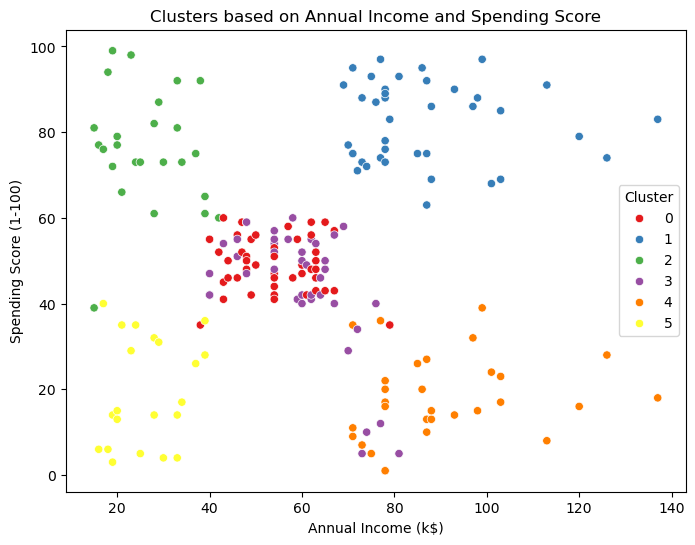

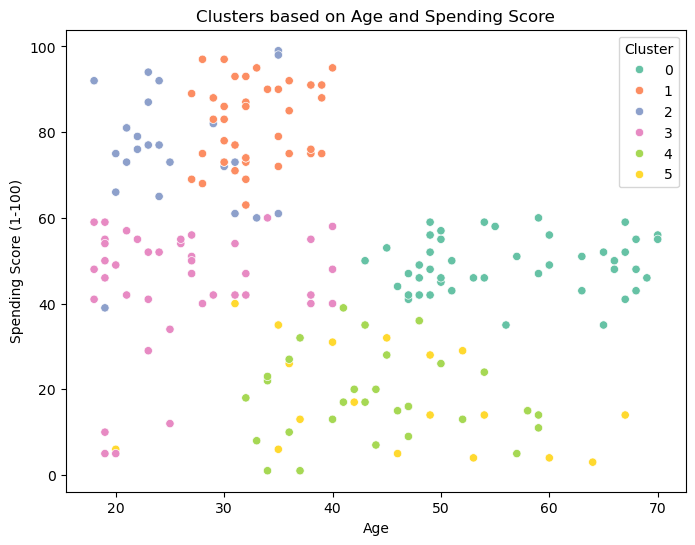

In [178]:
# Scatter plot based on Annual Income and Spending Score
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster', palette='Set1')
plt.title('Clusters based on Annual Income and Spending Score')
plt.show()

# Scatter plot based on Age and Spending Score
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='Age', y='Spending Score (1-100)', hue='Cluster', palette='Set2')
plt.title('Clusters based on Age and Spending Score')
plt.show()

3. **`Describe Each Cluster`**:

In [179]:
# Group by cluster and calculate mean values
cluster_summary = df.groupby('Cluster').mean()
print(cluster_summary)


         CustomerID    Gender        Age  Annual Income (k$)  \
Cluster                                                        
0         83.777778  0.422222  56.333333           54.266667   
1        162.000000  0.461538  32.692308           86.538462   
2         24.200000  0.440000  25.560000           26.480000   
3         97.700000  0.400000  26.125000           59.425000   
4        167.066667  0.533333  44.000000           90.133333   
5         23.190476  0.380952  45.523810           26.285714   

         Spending Score (1-100)  
Cluster                          
0                     49.066667  
1                     82.128205  
2                     76.240000  
3                     44.450000  
4                     17.933333  
5                     19.380952  


<div dir="rtl">
با توجه به نتایج بالا گروه های ۱ و ۲ را می‌توان ترغیب کرد . گروه یک در بازه سنی ۳۰ سال است و درامد بالایی دارد و همچنین مقدار زیادی خرج میکند. اما گروه دوم در بازه ۲۵ سال و جوان است. درامد بالایی ندارد ولی مقدار زیادی خرج میکند.

</div>

# ۶

1. ‍Experimenting with `n_clusters` as seen before

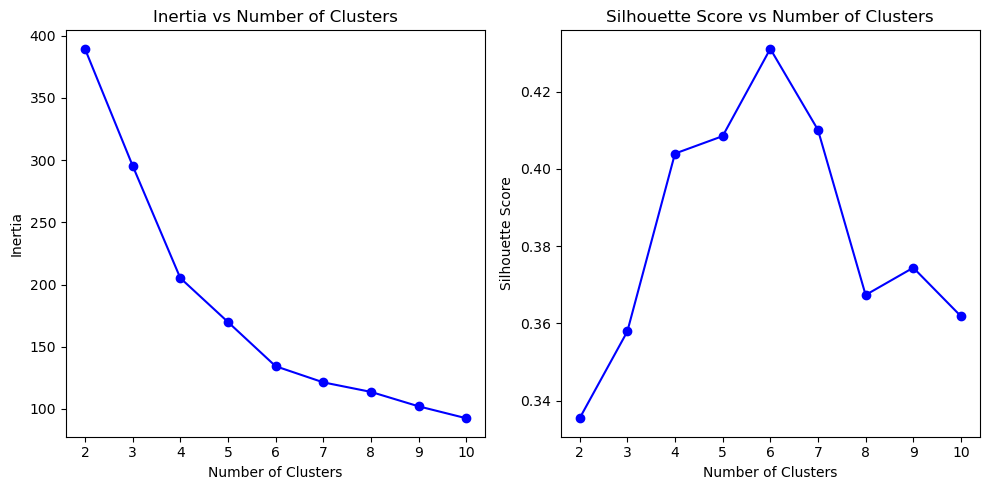

In [180]:
# List of clusters to try
cluster_range = range(2, 11)

# Store inertia and silhouette scores for each k
inertia = []
silhouette_scores = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    
    # Store the inertia
    inertia.append(kmeans.inertia_)
    
    # Store the silhouette score
    silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# Plotting the inertia and silhouette score for different values of k
plt.figure(figsize=(10,5))

# Plot for inertia
plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia, 'bo-')
plt.title('Inertia vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

# Plot for silhouette score
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, 'bo-')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

2. Experimenting with `init Method`

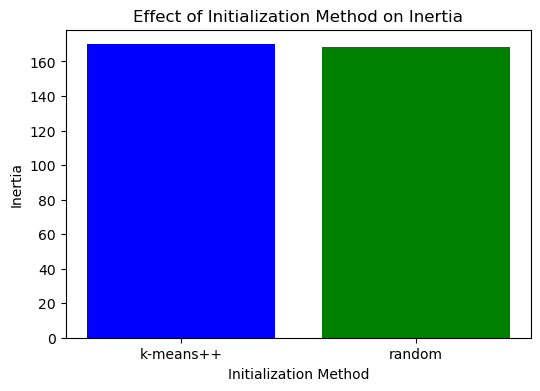

In [181]:
init_methods = ['k-means++', 'random']
init_inertia = []

for method in init_methods:
    kmeans = KMeans(n_clusters=5, init=method, random_state=42)
    kmeans.fit(X_scaled)
    
    # Store inertia for each method
    init_inertia.append(kmeans.inertia_)

# Bar plot to compare inertia for different init methods
plt.figure(figsize=(6,4))
plt.bar(init_methods, init_inertia, color=['blue', 'green'])
plt.title('Effect of Initialization Method on Inertia')
plt.xlabel('Initialization Method')
plt.ylabel('Inertia')
plt.show()

3. Experimenting with `n_init`

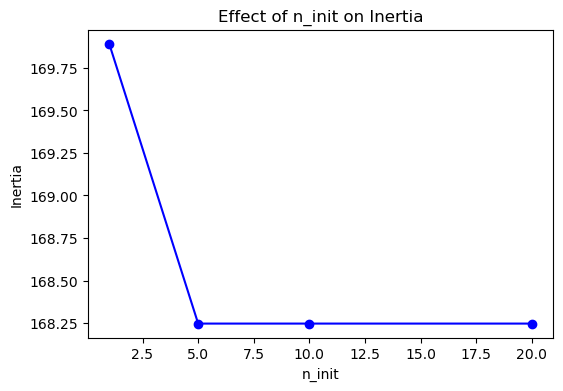

In [182]:
n_init_values = [1, 5, 10, 20]
n_init_inertia = []

for n in n_init_values:
    kmeans = KMeans(n_clusters=5, n_init=n, random_state=42)
    kmeans.fit(X_scaled)
    
    # Store inertia for each n_init
    n_init_inertia.append(kmeans.inertia_)

# Line plot for inertia vs n_init
plt.figure(figsize=(6,4))
plt.plot(n_init_values, n_init_inertia, 'bo-')
plt.title('Effect of n_init on Inertia')
plt.xlabel('n_init')
plt.ylabel('Inertia')
plt.show()


4. Experimenting with `max_iter`

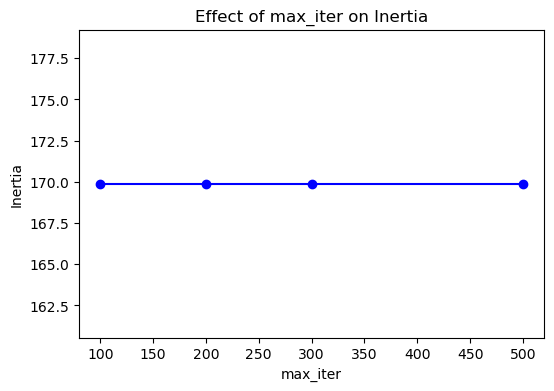

In [183]:
max_iter_values = [100, 200, 300, 500]
max_iter_inertia = []

for max_iter in max_iter_values:
    kmeans = KMeans(n_clusters=5, max_iter=max_iter, random_state=42)
    kmeans.fit(X_scaled)
    
    # Store inertia for each max_iter
    max_iter_inertia.append(kmeans.inertia_)

# Line plot for inertia vs max_iter
plt.figure(figsize=(6,4))
plt.plot(max_iter_values, max_iter_inertia, 'bo-')
plt.title('Effect of max_iter on Inertia')
plt.xlabel('max_iter')
plt.ylabel('Inertia')
plt.show()


5. Experimenting with `tol` (Tolerance)

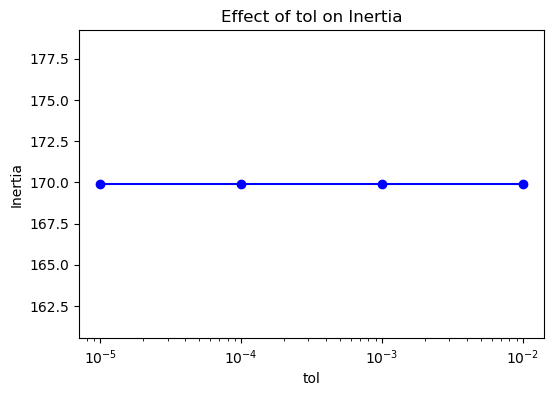

In [184]:
tol_values = [1e-2, 1e-3, 1e-4, 1e-5]
tol_inertia = []

for tol in tol_values:
    kmeans = KMeans(n_clusters=5, tol=tol, random_state=42)
    kmeans.fit(X_scaled)
    
    # Store inertia for each tolerance
    tol_inertia.append(kmeans.inertia_)

# Line plot for inertia vs tol
plt.figure(figsize=(6,4))
plt.plot(tol_values, tol_inertia, 'bo-')
plt.xscale('log')  # Use logarithmic scale for tolerance values
plt.title('Effect of tol on Inertia')
plt.xlabel('tol')
plt.ylabel('Inertia')
plt.show()


6. Experimenting with `algorithm`

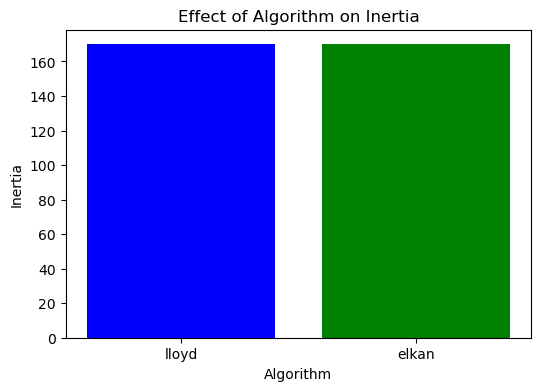

In [186]:
algorithms = ['lloyd', 'elkan']
algorithm_inertia = []

for algo in algorithms:
    kmeans = KMeans(n_clusters=5, algorithm=algo, random_state=42)
    kmeans.fit(X_scaled)
    
    # Store inertia for each algorithm
    algorithm_inertia.append(kmeans.inertia_)

# Bar plot to compare inertia for different algorithms
plt.figure(figsize=(6,4))
plt.bar(algorithms, algorithm_inertia, color=['blue', 'green'])
plt.title('Effect of Algorithm on Inertia')
plt.xlabel('Algorithm')
plt.ylabel('Inertia')
plt.show()
